# WCM with Particle Swarm Optimization of parameters for KGE minimization

In [1]:
"""
c.massari - s.modanesi 08/11/2022
define WCM(PAR[i], data_in) 
#può essere usato con modello di suolo + WCM o WCM o modello di suolo
"""

'\nc.massari - s.modanesi 08/11/2022\ndefine WCM(PAR[i], data_in) \n#può essere usato con modello di suolo + WCM o WCM o modello di suolo\n'

In [2]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
# import fiona
import xarray as xr
import hydroeval as he
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.utils.functions.single_obj import sphere

# Forward and backwards model

In [3]:
# Ausiliary functions

#-----------------------------------------------------------------------------

def lin_db(x):
    return 10*np.log10(x)

def db_lin(x):
    return 10**(x/10)

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def linear(x,a,b):
    return a+b*x

def bias(obs, sim):
    if len(obs)==len(sim):
        return np.mean(obs-sim)
    else: raise ValueError(
        f'obs and sim must have same first dimension, but have shapes {np.shape(obs)} and {np.shape(sim)}')

#-----------------------------------------------------------------------------

In [4]:
def WCM(PAR, data_in):
    """Water Cloud Model calibration.
    
    This function simulates backscattering with WCM and returns
    the KGE index to perform its minimization for calibration
    of parameters A,B,C,D of the WCM.
    
    Inputs
    ------
    - PAR: list
        List of initial guesses for the parameters to calibrate.
    - data_in: list
        List of inputs of observables, that must be in the form:
        [SM,LAI,t_deg,obs], being SM = soil moisture,
        LAI = Leaf Area Index, t_deg = angle of observation,
        obs = observed total sigma0
    
    Return
    ------
    KGE between simulated and observed backscattering.
    
    """

    A,B,C,D = PAR # parameters
    SM,LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    sig0s_dB = C+D*SM # define bare soil backscatter [dB]
    sig0s = db_lin(sig0s_dB) # from dB to linear scale
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation
    sig0_lin = T2*sig0s+sig0v
    sig0=lin_db(sig0_lin) # from linear scale to dB
        
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [sig0,KGE] # AT THE MOMENT THE OUTPUT IS THE KGE FOR MINIMIZATION OF IT

#-----------------------------------------------------------------------------

def SM_fromWCM(PAR, data_in):
    """Inverted WCM for SM estimation.
    
    """

    A,B,C,D = PAR # parameters
    SM,LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation [lin]
    sig0s_lin = (db_lin(obs)-sig0v)/T2
    SMretr = (lin_db(sig0s_lin)-C)/D
    
    OUT=he.evaluator(he.kge, SMretr, SM) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [SMretr,KGE]

#-----------------------------------------------------------------------------

def pso_calib(PAR):
    global data_in
    global calib
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        if calib=='1': sig0,KGE = WCM(PAR[i], data_in)
        elif calib=='2': SMretr,KGE = SM_fromWCM(PAR[i], data_in)
        else: raise NameError('Please choose one of the options.')
        err[i] = 1-KGE
    return err

#-----------------------------------------------------------------------------

# Forw and backw model rewritten in one-line

# Input data

Plot inputs? [y/n] y
Save fig? [[]/(any)] n


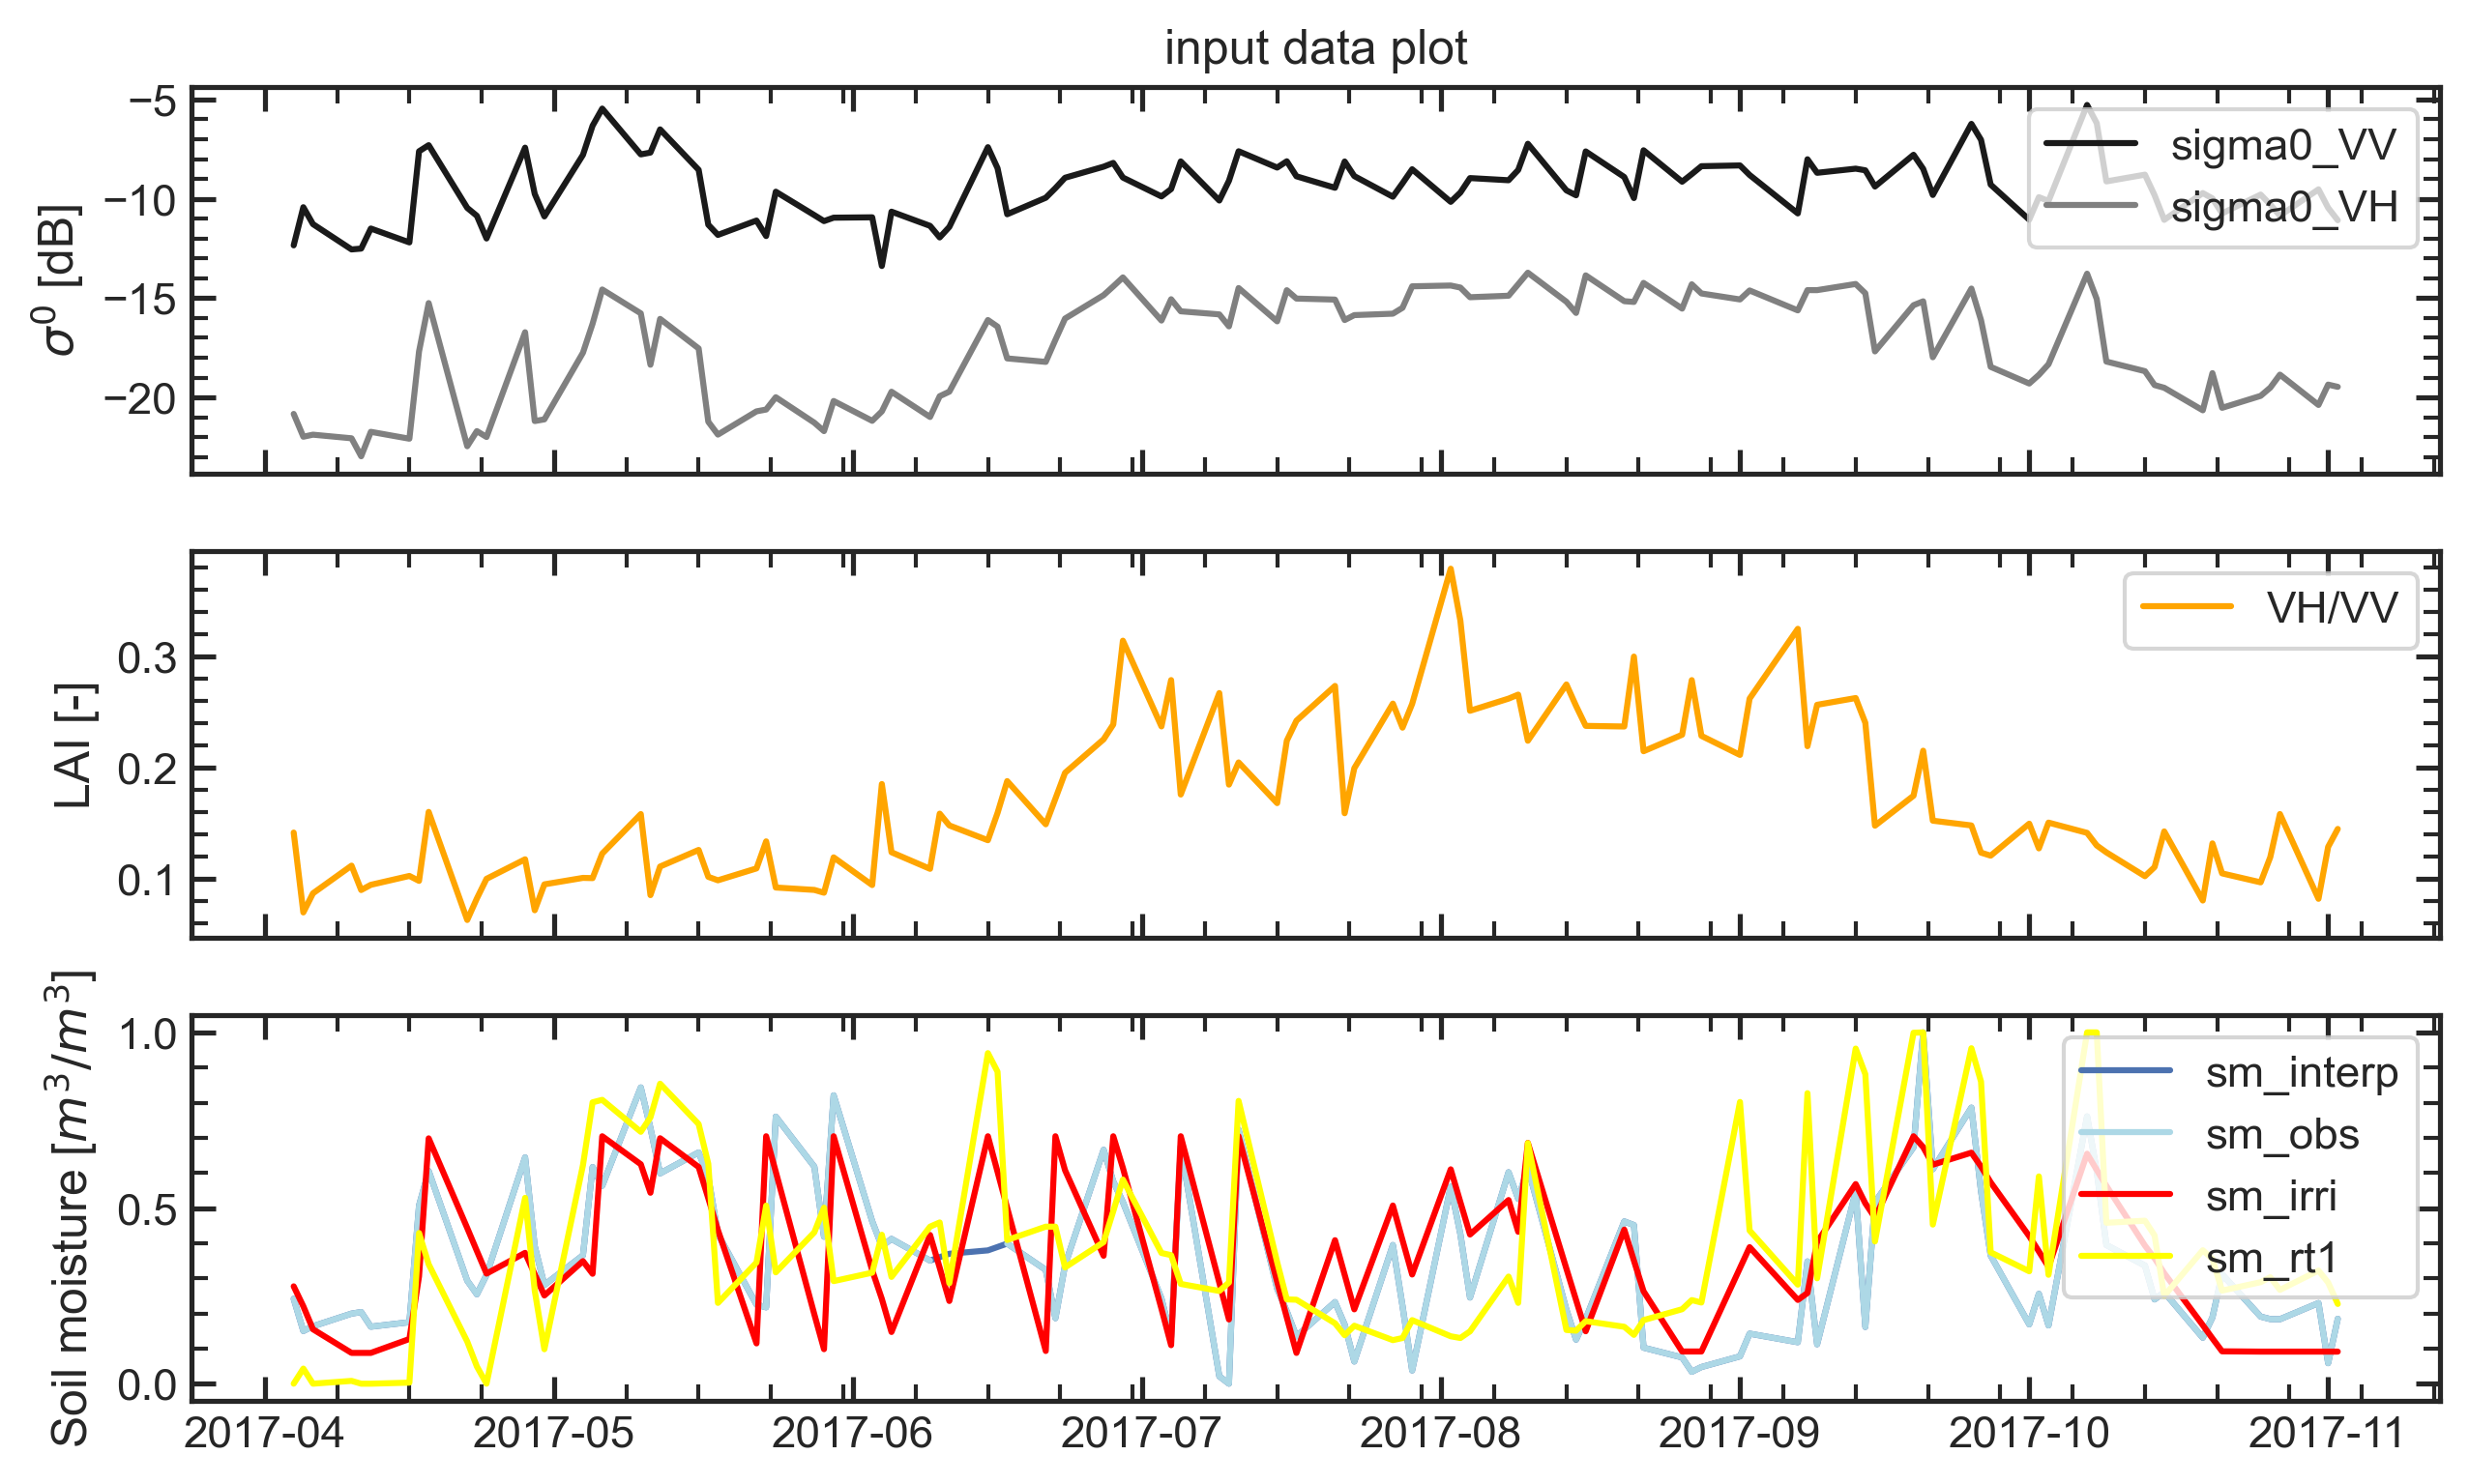

In [5]:
# Getting data
df = pd.read_csv('..\Data\data_in.csv', delimiter='\t', index_col=0); # df

# Temporal, spatial
d = df['Date'].apply(lambda x : np.datetime64(x)).values

# Soil moisture
SM_unnorm = df['SWC[m3/m3]'].interpolate(method='linear').values 
SM_norm = norm(df['SWC[m3/m3]'].interpolate(method='linear').values) # normalized
SM_gap = (df['SWC[m3/m3]'].values-np.min(SM_unnorm))/(np.max(SM_unnorm)-np.min(SM_unnorm)) # normalized
SM_irri = df['SM_irri[-]'].interpolate(method='linear').values # already normalized
rt1 = df['RT1[-]']#.interpolate(method='linear').values # already normalized

# Backscattering
t_deg = df['Angle[°]'].values
obs = df['VV_norm[dB]'].values#.interpolate(method='linear').values
obs_VH = df['VH_norm[dB]'].values#.interpolate(method='linear').values

# Vegetation indexes
LAI = df['LAI[m2/m2]'].values
cr = (db_lin(obs_VH)/db_lin(obs))

#-----------------------------------------------------------------------------
# NOTE: irrigation and precipitation from Golden_GEE may not be plotted
# since the database only takes hourly values consistent with satellite obs
# and retrieving daily sums is impossible from that database
# refer to Platinum_Budrio to retrieve daily, code is below

# # Budrio field data from Platinum tables
# platinum = pd.ExcelFile('Platinum_Budrio.xlsx', engine='openpyxl')
# platinum = platinum.parse('2017_1h')
# platinum['Ora_1'] = pd.to_datetime(platinum['Ora'].astype('str')).apply(lambda x: x.time())
# platinum['Data_1'] = pd.to_datetime(platinum['Data'].astype('str')).apply(lambda x: x.date())
# platinum['Date'] = platinum.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
# platinum = platinum.drop(['ID', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
# 
# # Other inputs
# P = platinum.resample('1D',on='Date').sum()['Pioggia[mm]'].values
# EPOT = df.set_index('Time_days').loc[D][f'PET_{siteID}'].values # evapotranspiration (measured)
# IRRobs = platinum.resample('1D',on='Date').sum()['Irrigazione[mm]'].values
# Wobs = platinum.resample('1D',on='Date').mean()['SWC[m3/m3]'].interpolate(method='linear').values
#-----------------------------------------------------------------------------

if input('Plot inputs? [y/n]')=='y':

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,6),dpi=300)
    ax[0].plot(d, obs, label='sigma0_VV', color='k')
    ax[0].plot(d, obs_VH, label='sigma0_VH', color='gray')
    # ax[0].plot(d, norm(t_deg), label='angle of obs')
    ax[0].set_title('input data plot')
    ax[0].legend(loc='upper right')
    ax[0].set_ylabel('$\sigma^0$ [dB]')
    
    #ax[1].plot(d, norm(LAI), label='LAI', color='green')
    #ax[1].plot(d, norm(cr), label='VH/VV', color='orange') # normalized for visualization reasons only
    ax[1].plot(d, cr, label='VH/VV', color='orange') # normalized for visualization reasons only
    # ax[1].plot(d, norm(np.flip(linear(obs_VH)/linear(obs))), label='VH/VV')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('LAI [-]')
    
    # NOTE: irrigation and precipitation from Golden_GEE may not be plotted
    # since the database only takes hourly values consistent with satellite obs 
    
    ax[2].plot(d, SM_norm, color='b', label='sm_interp')
    ax[2].plot(d, SM_gap, color='lightblue', label='sm_obs')
    ax[2].plot(d, SM_irri, color='red', label='sm_irri')
    ax[2].plot(d, rt1, color='yellow', label='sm_rt1')
    # ax[2].plot(d, IRR, label='irrigation')
    # ax[2].plot(d, P, label='rain')
    ax[2].legend(loc='upper right')
    ax[2].set_ylabel('Soil moisture [$m^3/m^3$]')
    
    if input('Save fig? [[]/(any)]')=='':
        plt.savefig('WCM_plot_inputs_irri.png')

R= 0.37180326265405333 R^2= 0.13823766612019897


Text(0.5, 1.0, '$\\sigma^0$ vs relative sm - R=0.37, R2=0.14')

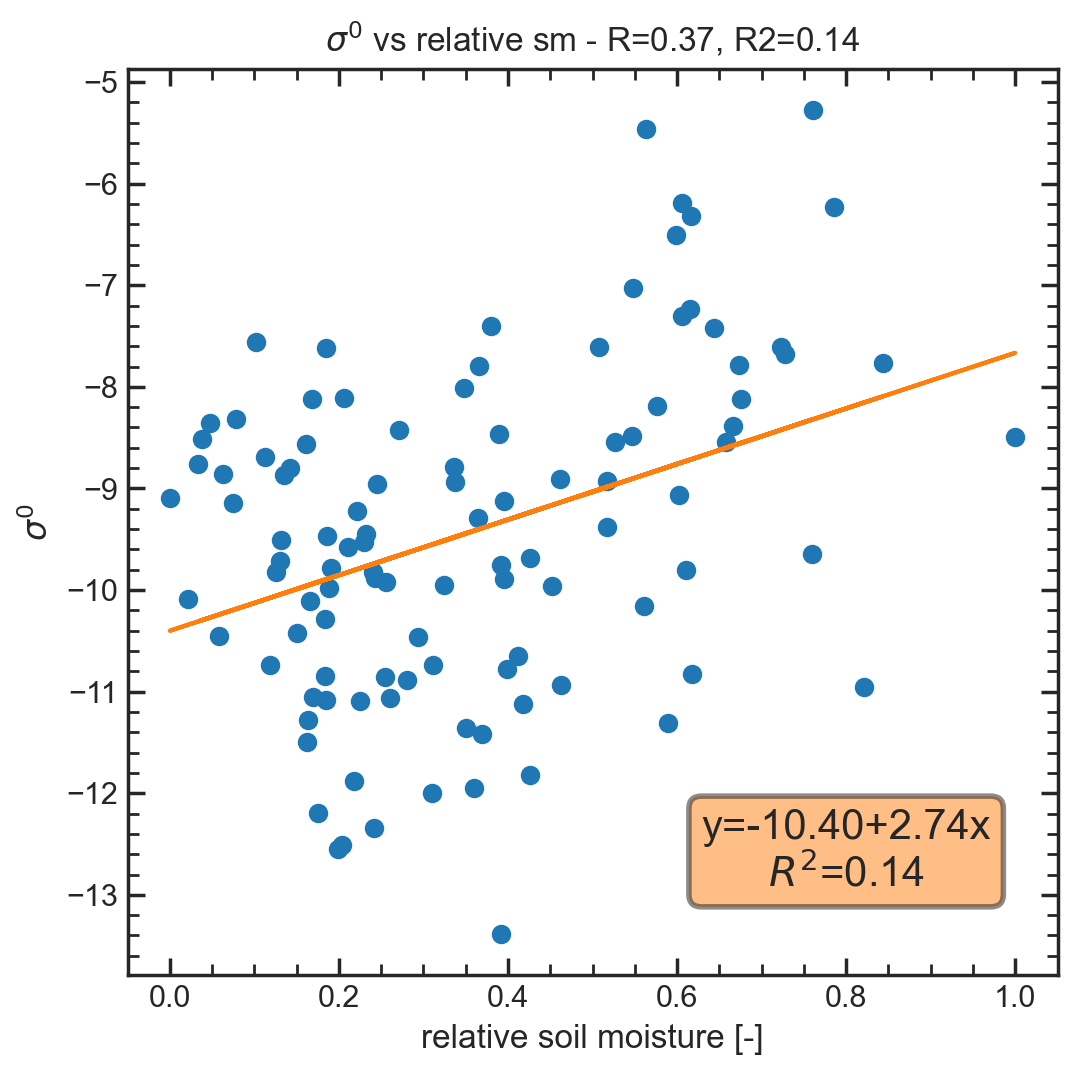

In [33]:
# Scatterplot, all period, all orbits, sm VS sigma0

sm = SM_norm

plt.figure(figsize=(6,6), dpi=200)
plt.plot(sm, obs, marker='o', linestyle='', color='tab:blue')

# Fit
popt, pcov = curve_fit(linear, sm, obs)
plt.plot(sm, linear(np.array(sm),*popt), color='tab:orange')
R=np.corrcoef(sm,obs)[0][1]; print('R=', R, 'R^2=', R**2)

plt.xlabel(r'relative soil moisture [-]'); plt.ylabel(r'$\sigma^0$')
#plt.xlim(0,1); plt.ylim(0,1)
xtext=0.8*(np.max(sm)-np.min(sm))+np.min(sm)  ; ytext=0.1*(np.max(obs)-np.min(obs))+np.min(obs)
t = plt.text(xtext, ytext,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

plt.title(r'$\sigma^0$ vs relative sm - ' + f'R={R:.2f}, R2={R**2:.2f}')

# if save: plt.savefig(f'sim-vs-sat\\sim-vs-sat_{sat}_scatter.png')

Please provide name of vegetation index to use as input. [Options: LAI, cr, vh] cr
Please provide name of soil moisture product to use as input. [Options: situ, irri] irri
Calibrate on sigma0 or sm? [1 for sigma0, 2 for sm] 1
Number of runs:  1
Number of particles:  20
Number of optimization steps:  200
Verbose? [t/f] t
Global or Local PSO optimizer? [[global]/local]  


2022-11-23 16:40:55,381 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.539
2022-11-23 16:40:58,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5391157244120239, best pos: [  0.29886365   0.37247638 -12.47009194   8.40554988]


Params = [A, B, C, D]
 [  0.29886365   0.37247638 -12.47009194   8.40554988]
RMSE = 1.3669352702162278e-16
R= 0.9999999999999999


Save cost history plot? [[]/(any)] n
Save plot? [[]/(any)] n


<Figure size 1800x1200 with 0 Axes>

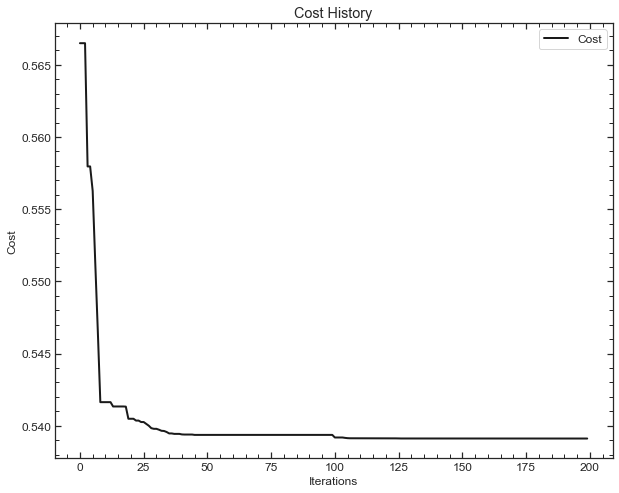

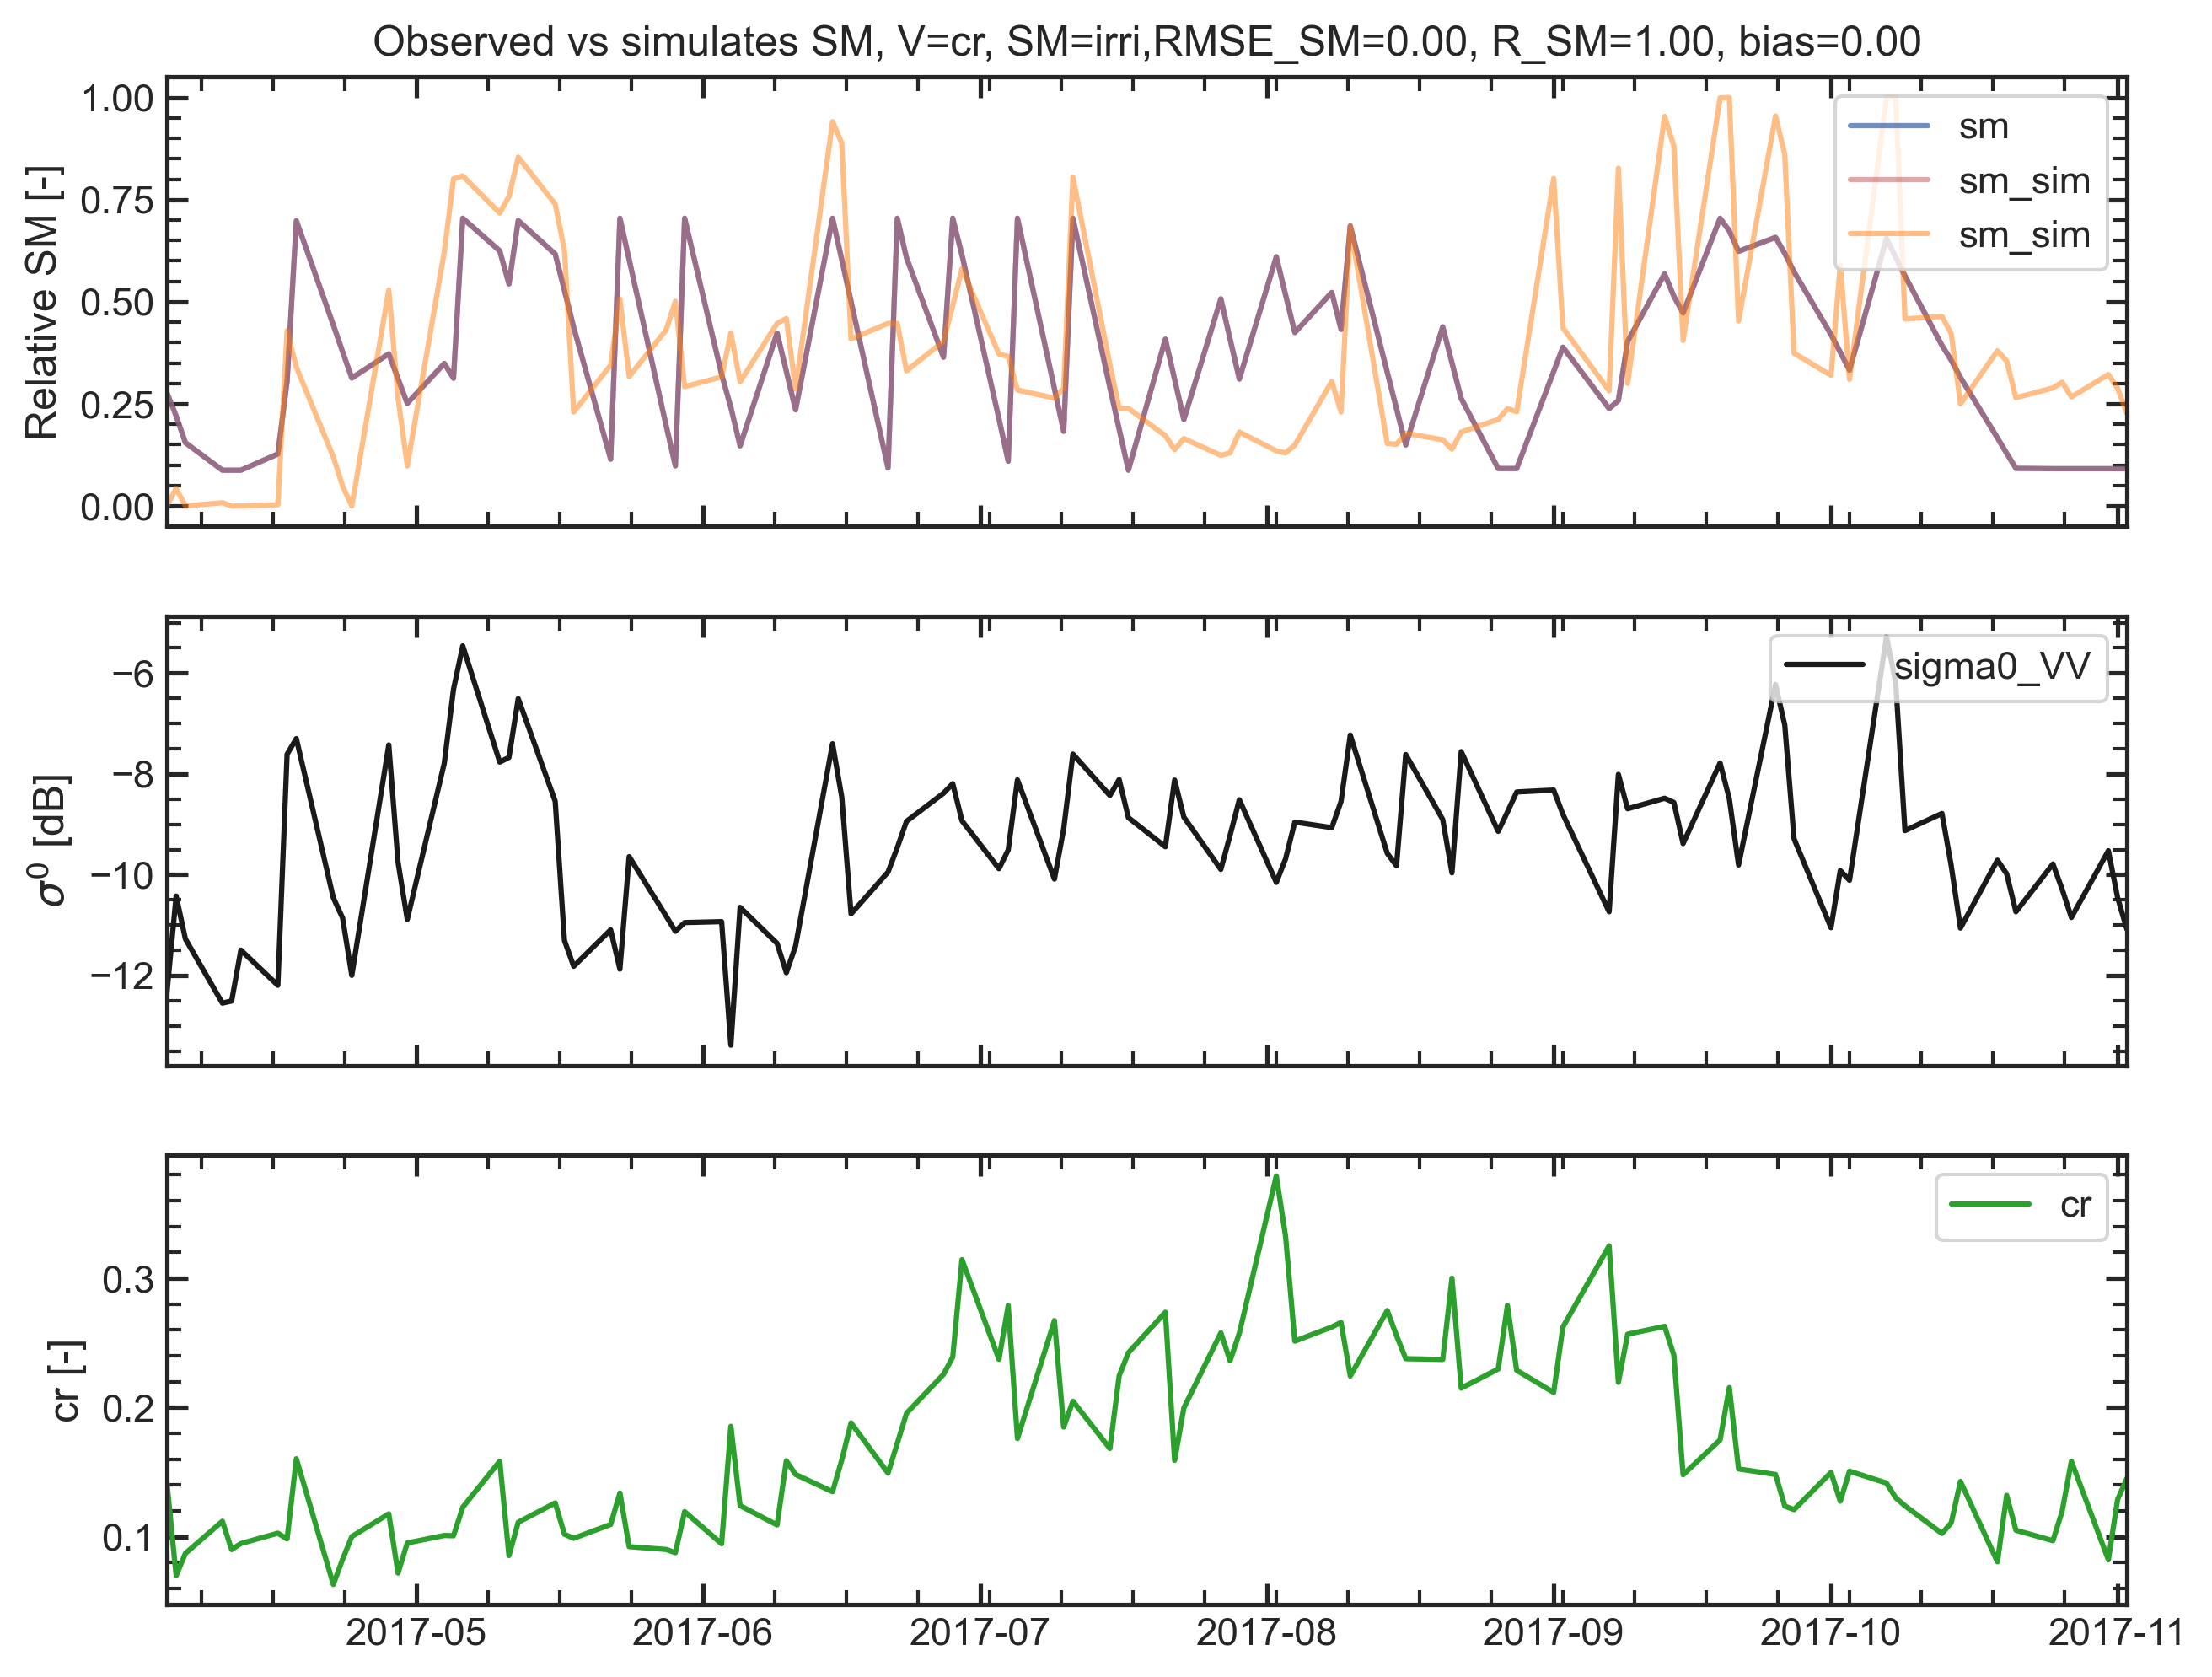

In [37]:
#-----------------------------------------------------------------------------
# Calibration
#-----------------------------------------------------------------------------
index = input('Please provide name of vegetation index to use as input. [Options: LAI, cr, vh]')
if index=='LAI': veg=LAI
elif index=='cr': veg=cr
elif index=='vh': veg=db_lin(obs_VH)
else: raise NameError('Please select one of the available options')

soilm = input('Please provide name of soil moisture product to use as input. [Options: situ, irri]')
if soilm=='situ': SM=SM_norm
elif soilm=='irri': SM=SM_irri
else: raise NameError('Please select one of the available options')

calib = input('Calibrate on sigma0 or sm? [1 for sigma0, 2 for sm]')

data_in=[SM,veg,t_deg,obs]
PAR=[0.1,0.1,-10,3] # [A,B,C,D] and some guess values
bounds = (np.array([0, 0, -20, 0]), # min
          np.array([0.3, 0.4,-5,10])) # max
# from Modanesi_2022

#-----------------------------------------------------------------------------
# Build an array of parameters to evaluate their distribution
params=[]
nrun = int(input('Number of runs: '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
verbose = True if input('Verbose? [t/f]')=='t' else False
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norm = 1 if input('Which norm? [l1/l2] ')=='l1' else 2

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR), options=options, bounds=bounds)
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norm }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles, dimensions=len(PAR), options=options, bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    cost, PARn = optimizer.optimize(pso_calib, n_step, verbose=verbose)
    params.append(PARn)
    i+=1

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

#-----------------------------------------------------------------------------
# Forward model
#-----------------------------------------------------------------------------
sigma0_retr,KGE = WCM(PARn, data_in)
print('Params = [A, B, C, D]\n', PARn)

#-----------------------------------------------------------------------------
# Inverse model
#-----------------------------------------------------------------------------
data_val = [SM,veg,t_deg,sigma0_retr]
SM_retr,KGE=SM_fromWCM(PARn, data_val);

#-----------------------------------------------------------------------------
# Model performance
#-----------------------------------------------------------------------------
NS=1-np.nansum((SM_retr-SM)**2)/np.nansum((SM-np.nanmean(SM))**2)
NS_radQ=1-np.nansum((np.sqrt(SM_retr+0.00001)-np.sqrt(SM+0.00001))**2)/np.nansum((np.sqrt(SM+0.00001)-np.nanmean(np.sqrt(SM+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(SM_retr+0.0001)-np.log(SM+0.0001))**2)/np.nansum((np.log(SM+0.0001)-np.nanmean(np.log(SM+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
SM_RMSE=np.mean((SM_retr-SM)**2)**0.5; print('RMSE =', SM_RMSE)
R=np.corrcoef(SM_retr,SM)[0][1]; print('R=', R)

#-----------------------------------------------------------------------------
# Optimizer performance and plot cost history
#-----------------------------------------------------------------------------
from pyswarms.utils.functions.single_obj import sphere
from pyswarms.utils.plotters import plot_cost_history

plt.figure(dpi=300)
cost_history = optimizer.cost_history
plot_cost_history(cost_history)
if input('Save cost history plot? [[]/(any)]')=='':
    plt.savefig('cost_plot_WCM_v1.png')

#-----------------------------------------------------------------------------
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,8),dpi=300)

ax[0].set_title(f'Observed vs simulates SM, V={index}, SM={soilm},'+
                f'RMSE_SM={SM_RMSE:.2f}, R_SM={R:.2f}, bias={bias(SM,SM_retr):.2f}')

ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1])
ax[0].plot(d, SM, color='b', label='sm', alpha=.8)
if SM[10]==SM_norm[10]: ax[0].plot(d, SM_gap, color='lightblue', label='sm_obs')
ax[0].plot(d, SM_retr, color='r', label='sm_sim', alpha=.5)
ax[0].plot(d, rt1, color='tab:orange', label='sm_sim', alpha=.5)

ax[0].legend(loc='upper right')
ax[0].set_ylabel('Relative SM [-]')

ax[1].plot(d, obs, label='sigma0_VV', color='k')
#ax[1].plot(d, obs_VH, label='sigma0_VH', color='gray')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('$\sigma^0$ [dB]')

ax[2].plot(d, veg, label=f'{index}', color='tab:green')
ax[2].legend(loc='upper right')
ax[2].set_ylabel(f'{index} [-]')

if input('Save plot? [[]/(any)]')=='':
    plt.savefig('WCM.png')

R= 0.5616537859692973 R^2= 0.3154549752936452


Text(0.5, 1.0, '$\\sigma^0$ vs relative sm - R=0.56, R2=0.32')

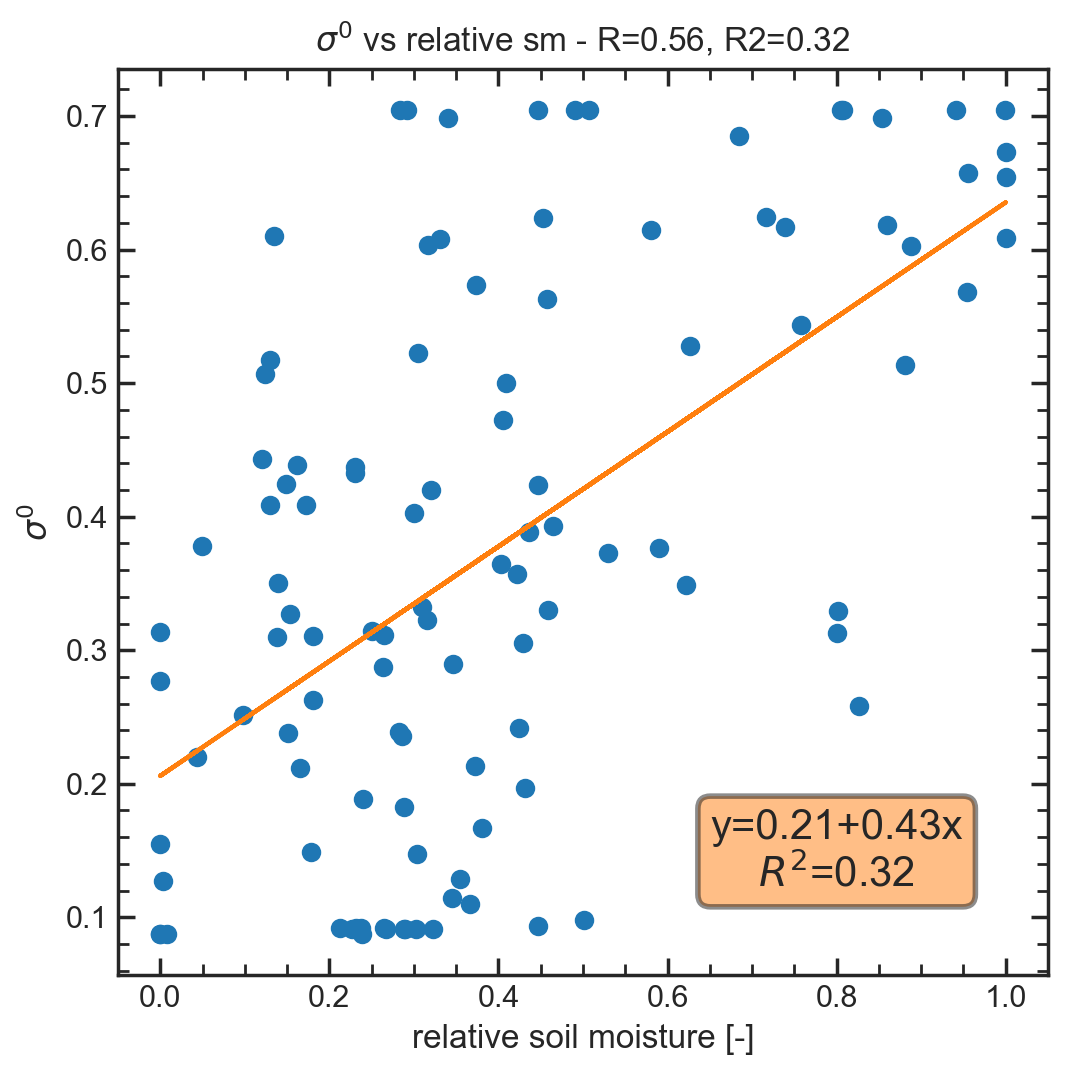

In [38]:
# Scatterplot, all period, all orbits, sm VS sigma0

x = rt1
y = SM_retr

plt.figure(figsize=(6,6), dpi=200)
plt.plot(x, y, marker='o', linestyle='', color='tab:blue')

# Fit
popt, pcov = curve_fit(linear, x, y)
plt.plot(x, linear(np.array(x),*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)

plt.xlabel(r'relative soil moisture [-]'); plt.ylabel(r'$\sigma^0$')
#plt.xlim(0,1); plt.ylim(0,1)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
t = plt.text(xtext, ytext,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

plt.title(r'$\sigma^0$ vs relative sm - ' + f'R={R:.2f}, R2={R**2:.2f}')

# if save: plt.savefig(f'sim-vs-sat\\sim-vs-sat_{sat}_scatter.png')

## Snippets